In [1]:
#!unzip animal_dataset.zip

# Dataset Exploration

The dataset has 3 classes:
- cats
- dogs
- panda

The task is to conduct classification

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

data_dir = "./animals/animals"

# PREPROCESS

t = transforms.Compose([transforms.Resize((299,299)), # Menyesuaikan model yang digunakan, XCeption
                        transforms.ToTensor()])

# LOAD DATASET

dataset = datasets.ImageFolder(data_dir, transform=t)

In [3]:
import torch
# SPLIT DATASET
torch.manual_seed(42)

train_ratio = 0.8
val_ratio = 0.1 # test ratio = 0.1
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - (train_size + val_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [4]:
composition = {
    "train" : dict(),
    "val" : dict(),
    "test" : dict()
}
for _, l in train_set:
    if l not in composition["train"]:
        composition["train"][l] = 0
    composition["train"][l] += 1

for _, l in val_set:
    if l not in composition["val"]:
        composition["val"][l] = 0
    composition["val"][l] += 1

for _, l in test_set:
    if l not in composition["test"]:
        composition["test"][l] = 0
    composition["test"][l] += 1

In [5]:
composition

{'train': {1: 794, 0: 796, 2: 810},
 'val': {0: 114, 1: 97, 2: 89},
 'test': {0: 90, 1: 109, 2: 101}}

Karena cukup balance antara kelas-kelasnya, digunakan metrics akurasi nantinya

In [6]:
# DATALOADER

BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Create Model

Paper reference :

1. https://ieeexplore.ieee.org/document/9730565
2. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8
3. https://ieeexplore.ieee.org/document/10183255

Mengikuti paper ke-2, berdasarkan tabel di halaman 27, dipilih Xception dikarenakan adanya perbandingan pada dataset ImageNet dan diperoleh hasil yang paling baik dengan error rate sebesar 0.055

* Paper xception : https://arxiv.org/pdf/1610.02357.pdf
* Referensi kode xception (tensorflow version) : https://www.linkedin.com/pulse/xception-from-scratch-using-keras-api-ayoub-kirouane/
* Referensi implementasi SeperableConv2d pada pytorch : https://stackoverflow.com/questions/65154182/implement-separableconv2d-in-pytorch
* Referensi implementasi padding="same" pada pytorch : https://stackoverflow.com/questions/62166719/padding-same-conversion-to-pytorch-padding

![architecture-xception](xception.png)

In [7]:
import torch.nn.functional as F
import math

class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        kernel_size = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size
        stride = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride
        dilation = (self.dilation, self.dilation) if isinstance(self.dilation, int) else self.dilation

        pad_h = self.calc_same_pad(i=ih, k=kernel_size[0], s=stride[0], d=dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=kernel_size[1], s=stride[1], d=dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

class MaxPool2dSame(torch.nn.MaxPool2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        kernel_size = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size
        stride = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride
        dilation = (self.dilation, self.dilation) if isinstance(self.dilation, int) else self.dilation

        pad_h = self.calc_same_pad(i=ih, k=kernel_size[0], s=stride[0], d=dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=kernel_size[1], s=stride[1], d=dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.max_pool2d(
            x,
            self.kernel_size,
            self.stride,
            self.padding,
            self.dilation,
            self.ceil_mode,
            self.return_indices
        )

In [8]:
class SeparableConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(SeparableConv2d, self).__init__()
        # Depthwise convolution
        self.depthwise = Conv2dSame(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        # Pointwise convolution
        self.pointwise = Conv2dSame(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [9]:
class EntryFlow(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2dSame(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(2,2))
        self.bn1 = torch.nn.BatchNorm2d(num_features=32)
        self.conv2 = Conv2dSame(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.bn2 = torch.nn.BatchNorm2d(num_features=64)

        self.res_conv1 = Conv2dSame(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2))
        self.bn3 = torch.nn.BatchNorm2d(num_features=128)

        self.sep_conv1 = SeparableConv2d(in_channels=64, out_channels=128, kernel_size=(3,3))
        self.bn4 = torch.nn.BatchNorm2d(num_features=128)
        self.sep_conv2 = SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
        self.bn5 = torch.nn.BatchNorm2d(num_features=128)

        self.res_conv2 = Conv2dSame(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2))
        self.bn6 = torch.nn.BatchNorm2d(num_features=256)

        self.sep_conv3 = SeparableConv2d(in_channels=128, out_channels=256, kernel_size=(3,3))
        self.bn7 = torch.nn.BatchNorm2d(num_features=256)
        self.sep_conv4 = SeparableConv2d(in_channels=256, out_channels=256, kernel_size=(3,3))
        self.bn8 = torch.nn.BatchNorm2d(num_features=256)

        self.res_conv3 = Conv2dSame(in_channels=256, out_channels=728, kernel_size=(1,1), stride=(2,2))
        self.bn9 = torch.nn.BatchNorm2d(num_features=728)

        self.sep_conv5 = SeparableConv2d(in_channels=256, out_channels=728, kernel_size=(3,3))
        self.bn10 = torch.nn.BatchNorm2d(num_features=728)
        self.sep_conv6 = SeparableConv2d(in_channels=728, out_channels=728, kernel_size=(3,3))
        self.bn11 = torch.nn.BatchNorm2d(num_features=728)

        self.max_pool = MaxPool2dSame(kernel_size=(3,3), stride=(2,2))

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.relu(self.bn1(x1))

        x1 = self.conv2(x1)
        x1 = F.relu(self.bn2(x1))

        # Residual 1
        x2 = self.res_conv1(x1)
        x2 = self.bn3(x2)

        x1 = self.sep_conv1(x1)
        x1 = F.relu(self.bn4(x1))
        x1 = self.sep_conv2(x1)
        x1 = self.bn5(x1)
        x1 = self.max_pool(x1)

        x1 = x1 + x2

        # Residual 2
        x2 = self.res_conv2(x1)
        x2 = self.bn6(x2)

        x1 = self.sep_conv3(x1)
        x1 = F.relu(self.bn7(x1))
        x1 = self.sep_conv4(x1)
        x1 = self.bn8(x1)
        x1 = self.max_pool(x1)

        x1 = x1 + x2

        # Residual 3
        x2 = self.res_conv3(x1)
        x2 = self.bn9(x2)

        x1 = self.sep_conv5(x1)
        x1 = F.relu(self.bn10(x1))
        x1 = self.sep_conv6(x1)
        x1 = self.bn11(x1)
        x1 = self.max_pool(x1)

        x1 = x1 + x2

        return x1

In [10]:
class MiddleFlow(torch.nn.Module):
    def __init__(self, rep=8):
        super().__init__()
        self.rep = rep
        self.sep_conv1 = SeparableConv2d(in_channels=728, out_channels=728, kernel_size=(3,3))
        self.bn1 = torch.nn.BatchNorm2d(num_features=728)
        self.sep_conv2 = SeparableConv2d(in_channels=728, out_channels=728, kernel_size=(3,3))
        self.bn2 = torch.nn.BatchNorm2d(num_features=728)
        self.sep_conv3 = SeparableConv2d(in_channels=728, out_channels=728, kernel_size=(3,3))
        self.bn3 = torch.nn.BatchNorm2d(num_features=728)
    
    def forward(self, x):
        for _ in range(self.rep):
            x2 = F.relu(x)
            x2 = self.sep_conv1(x2)
            x2 = self.bn1(x2)

            x2 = F.relu(x2)
            x2 = self.sep_conv2(x2)
            x2 = self.bn2(x2)

            x2 = F.relu(x2)
            x2 = self.sep_conv3(x2)
            x2 = self.bn3(x2)

            x = x + x2
        return x

In [11]:
class GlobalMaxPooling2D(torch.nn.Module):
    def forward(self, x):
        # Perform global max pooling across spatial dimensions
        return F.max_pool2d(x, kernel_size=x.size()[2:])

In [12]:
class ExitFlow(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.res_conv = Conv2dSame(in_channels=728, out_channels=1024, kernel_size=(1,1), stride=(2,2))
        self.bn1 = torch.nn.BatchNorm2d(num_features=1024)

        self.sep_conv1 = SeparableConv2d(in_channels=728, out_channels=728, kernel_size=(3,3))
        self.bn2 = torch.nn.BatchNorm2d(num_features=728)
        self.sep_conv2 = SeparableConv2d(in_channels=728, out_channels=1024, kernel_size=(3,3))
        self.bn3 = torch.nn.BatchNorm2d(num_features=1024)

        self.max_pool = MaxPool2dSame(kernel_size=(3,3), stride=(2,2))

        self.sep_conv3 = SeparableConv2d(in_channels=1024, out_channels=1536, kernel_size=(3,3))
        self.bn4 = torch.nn.BatchNorm2d(num_features=1536)
        self.sep_conv4 = SeparableConv2d(in_channels=1536, out_channels=2048, kernel_size=(3,3))
        self.bn5 = torch.nn.BatchNorm2d(num_features=2048)

        self.global_max_pool = GlobalMaxPooling2D()

        self.dense = torch.nn.Linear(in_features=2048, out_features=n_class, bias=True)

        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x1 = self.res_conv(x)
        x1 = self.bn1(x1)

        x2 = F.relu(x)
        x2 = self.sep_conv1(x2)
        x2 = self.bn2(x2)

        x2 = F.relu(x2)
        x2 = self.sep_conv2(x2)
        x2 = self.bn3(x2)

        x2 = self.max_pool(x2)

        x = x1 + x2

        x = self.sep_conv3(x)
        x = F.relu(self.bn4(x))

        x = self.sep_conv4(x)
        x = F.relu(self.bn5(x))

        x = self.global_max_pool(x)
        x = x.view(x.shape[0],-1)

        x = self.dense(x)

        x = self.log_softmax(x)

        return x

In [13]:
class XCeption(torch.nn.Module):
    def __init__(self, n_class, rep=8):
        super().__init__()
        self.entry_flow = EntryFlow()
        self.middle_flow = MiddleFlow(rep=rep)
        self.exit_flow = ExitFlow(n_class=n_class)
    
    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        return x

# Training

In [14]:
model = XCeption(n_class=3)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
count_parameters(model)

9535003

Optimizer menggunakan Adam agar cepat trainingnya, sehingga jumlah epoch sedikit

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [18]:
device

device(type='cuda', index=0)

In [19]:
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import numpy as np

EPOCH = 10

progress_bar = tqdm(total=EPOCH * (len(train_loader) + len(val_loader)))

hist = []

best_model_path = 'best_model.pth'

chosen_metrics = "accuracy"

best_metrics = 0 if chosen_metrics != "loss" else np.inf

for e in range(EPOCH):
    history_entry = dict()

    model.train()
    train_loss = 0
    y_true = []
    y_pred = []
    for inputs, labels in train_loader:
        y_true.extend(labels.tolist())
        inputs, labels = inputs.to(device), labels.to(device)
        # zero grad
        optimizer.zero_grad()
        # output
        out = model.forward(inputs)
        # loss
        loss = criterion(out, labels)
        train_loss += loss.item()
        # backward
        loss.backward()
        optimizer.step()

        # append to pred
        y_pred.extend(out.argmax(-1).cpu().tolist())

        progress_bar.update(1)
    train_loss /= len(train_set)
    train_report_str = classification_report(y_true=y_true, y_pred=y_pred)
    train_report_dict = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)

    history_entry["train_loss"] = train_loss
    history_entry["train_accuracy"] = train_report_dict["accuracy"]
    history_entry["train_f1_score"] = train_report_dict["weighted avg"]["f1-score"]
    history_entry["train_recall"] = train_report_dict["weighted avg"]["recall"]
    history_entry["train_precision"] = train_report_dict["weighted avg"]["precision"]

    print(f"### Epoch {e+1} ###")
    print(f"Train Loss : {train_loss}")
    print("Train Report :")
    print(train_report_str)
    
    # eval
    model.eval()
    val_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            y_true.extend(labels.tolist())
            inputs, labels = inputs.to(device), labels.to(device)
            out = model.forward(inputs)
            loss = criterion(out, labels)
            val_loss += loss.item()

            y_pred.extend(out.argmax(-1).cpu().tolist())

            progress_bar.update(1)
    val_loss /= len(val_set)
    val_report_str = classification_report(y_true=y_true, y_pred=y_pred)
    val_report_dict = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)

    history_entry["val_loss"] = val_loss
    history_entry["val_accuracy"] = val_report_dict["accuracy"]
    history_entry["val_f1_score"] = val_report_dict["weighted avg"]["f1-score"]
    history_entry["val_recall"] = val_report_dict["weighted avg"]["recall"]
    history_entry["val_precision"] = val_report_dict["weighted avg"]["precision"]

    print(f"Validation Loss : {val_loss}")
    print("Validation Report :")
    print(val_report_str)

    hist.append(history_entry)

    condition_best = best_metrics <= history_entry[f"val_{chosen_metrics}"] if chosen_metrics != "loss" else best_metrics >= history_entry[f"val_{chosen_metrics}"]

    if condition_best:
        best_metrics = history_entry[f"val_{chosen_metrics}"]
        torch.save({
            "state_dict" : model.state_dict(),
            "n_class" : 3
        }, best_model_path)

        print(f"Best model saved with val_{chosen_metrics} : {best_metrics}")

C:\Users\rando\AppData\Local\Temp\ipykernel_18428\2849249087.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/3380 [00:00<?, ?it/s]

### Epoch 1 ###
Train Loss : 0.13719782032072544
Train Report :
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       796
           1       0.47      0.47      0.47       794
           2       0.73      0.75      0.74       810

    accuracy                           0.58      2400
   macro avg       0.58      0.58      0.58      2400
weighted avg       0.58      0.58      0.58      2400

Validation Loss : 0.11981194386879603
Validation Report :
              precision    recall  f1-score   support

           0       0.50      0.96      0.66       114
           1       0.47      0.14      0.22        97
           2       0.94      0.55      0.70        89

    accuracy                           0.57       300
   macro avg       0.64      0.55      0.52       300
weighted avg       0.62      0.57      0.53       300

Best model saved with val_accuracy : 0.5733333333333334
### Epoch 2 ###
Train Loss : 0.09867450369521975
Train Repor

# Plot Training History

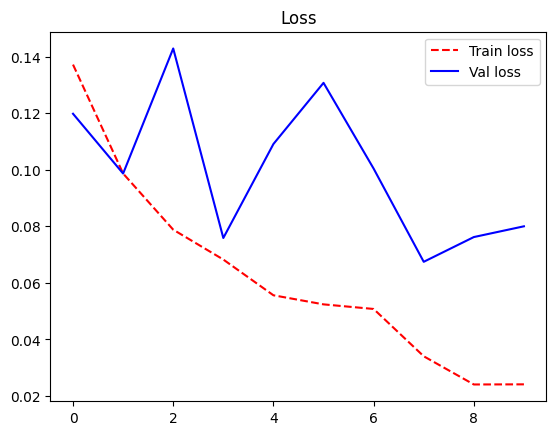

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

hist_df = pd.DataFrame(hist)

plt.plot(hist_df["train_loss"], label="Train loss", linestyle='--', color='r')
plt.plot(hist_df["val_loss"], label="Val loss", linestyle='-', color='b')
plt.title("Loss")
plt.legend()
plt.show()

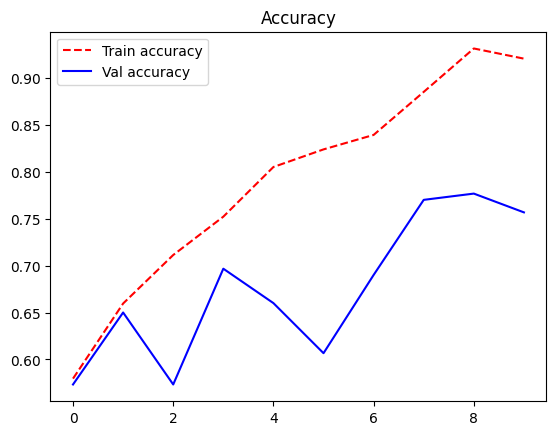

In [26]:
plt.plot(hist_df["train_accuracy"], label="Train accuracy", linestyle='--', color='r')
plt.plot(hist_df["val_accuracy"], label="Val accuracy", linestyle='-', color='b')
plt.title("Accuracy")
plt.legend()
plt.show()

# Test

In [27]:
state_dict = torch.load(best_model_path)

In [28]:
model.load_state_dict(state_dict=state_dict["state_dict"])

<All keys matched successfully>

In [29]:
model.to(device)

XCeption(
  (entry_flow): EntryFlow(
    (conv1): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res_conv1): Conv2dSame(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sep_conv1): SeparableConv2d(
      (depthwise): Conv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64)
      (pointwise): Conv2dSame(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sep_conv2): SeparableConv2d(
      (depthwise): Conv2dSame(128, 128, kernel_size=(3, 3), stride=(1, 1), groups=128)
      (pointwise): Conv2dSame(128, 128, kernel_size=(1, 1), stride=(1, 1)

In [30]:
model.eval()
test_loss = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        y_true.extend(labels.tolist())
        inputs, labels = inputs.to(device), labels.to(device)
        out = model.forward(inputs)
        loss = criterion(out, labels)
        test_loss += loss.item()

        y_pred.extend(out.argmax(-1).cpu().tolist())

        progress_bar.update(1)
test_loss /= len(test_set)
test_report_str = classification_report(y_true=y_true, y_pred=y_pred)

  0%|          | 0/38 [00:00<?, ?it/s]

In [31]:
print(test_loss)

0.06535668956736723


In [32]:
print(test_report_str)

              precision    recall  f1-score   support

           0       0.69      0.78      0.73        90
           1       0.73      0.73      0.73       109
           2       0.99      0.87      0.93       101

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.80       300
weighted avg       0.81      0.79      0.80       300

